In [1]:
#Import packages 
import numpy as np
import pandas as pd
import json

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


In [2]:
#Import packages and scrape data from wikipedia  
import requests
from bs4 import BeautifulSoup
URL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(URL).text


In [3]:
soup = BeautifulSoup(source,'lxml')
table = soup.find("table")

In [4]:
#Create 3 empty lists to store scraped data 
A=[]
B=[]
C=[]
#Loop through rows to get data for every postal code
for row in table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==3:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))

In [5]:
#Assign each list to a column title from source data
df=pd.DataFrame(A,columns=['Postal Code'])
df['Borough']=B
df['Neighborhood']=C
df.head()

,Postal Code,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M2A\n,Not assigned\n,Not assigned\n
2,M3A\n,North York\n,Parkwoods\n
3,M4A\n,North York\n,Victoria Village\n
4,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n"


In [6]:
#Replace cells with 'Not Assigned' with nan
df.replace('Not assigned\n', np.nan, inplace=True)

In [7]:
#Drop rows with Borough 'nan'
df.dropna(subset=['Borough'], axis=0, inplace=True)
#Reset index as we have removed rows
df.reset_index(drop=True, inplace=True)
#Tidy up dataframe by removing /n
df = df.replace('\n','',regex=True)

QUESTION 1: DATAFRAME SHOWING CANADA NEIGHBOURHOODS SCRAPED FROM WIKI

In [8]:
df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [9]:
df.shape

(103, 3)

Segmentation and Clustering

In [10]:
#!conda update -n base -c defaults conda -y
#!conda install -c conda-forge geocoder -y

In [10]:
import geocoder

In [ ]:
#Find postcode coordinates using geocoder
lat_lng_coords = None
while(lat_lng_coords is None):
    g = geocoder.google('{}, Toronto, Ontario'.format('df'))
    lat_lng_coords = g.latlng
    
latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]
#Error message that max retries exeeded so CSV file will be used instead

In [11]:
import csv

In [12]:
#Read csv file
geo_df = pd.read_csv('Geospatial_Coordinates.csv')
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


QUESTION 2: MERGED TABLES SHOWING POSTCAL CODES, LATITUDE & LONGITUDE OF CANADA BOROUGHS

In [14]:
#merge tables 
Canada = df.merge(geo_df, right_on='Postal Code', left_on = 'Postal Code')
Canada.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [19]:
#Drop Boroughs without Toronto in name from dataframe
toronto = Canada[Canada['Borough'].astype(str).str.contains('Toronto')]
toronto.reset_index(drop=True, inplace=True)
toronto.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


DATA ANALYSIS

In [114]:
#Foursquare credentials
CLIENT_ID = 'XXX'
CLIENT_SECRET = 'XXX'
VERSION = '20180605' #Foursquare API version
#Get neighbourhoos Latitudes and longitudes
neighborhood_lat = toronto.loc[0,'Latitude']
neighborhood_lon = toronto.loc[0,'Longitude']

neighborhood = toronto.loc[0,'Neighborhood']

In [21]:
#Create URL
LIMIT = 100
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_lat, 
    neighborhood_lon, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=0ZE2OWO1S5L5WGWKYRWXJK51W4WGPNQGEEMLS0J2WJESFA2Z&client_secret=OXVNL1A1204MDPPA3OPYQUH5ORIEN1G04IEDAZ1FW0PXIO54&v=20180605&ll=43.6542599,-79.3606359&radius=500&limit=100'

In [22]:
#send Get request
results = requests.get(url).json()

In [23]:
#Create a function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']      

In [24]:
#Clean up json file
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
3,Body Blitz Spa East,Spa,43.654735,-79.359874
4,Dominion Pub and Kitchen,Pub,43.656919,-79.358967


In [25]:
nearby_venues.shape

(44, 4)

In [26]:
# Create a function to repeat the get process for all neighbourhoods in Toronto
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
        

In [27]:
#Run function for each neighbourhood and create a new dataframe 'toronto_venues'
toronto_venues = getNearbyVenues(names=toronto['Neighborhood'],
                                   latitudes=toronto['Latitude'],
                                   longitudes=toronto['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


In [28]:
print(toronto_venues.shape)
toronto_venues.head()

(1614, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Dominion Pub and Kitchen,43.656919,-79.358967,Pub


In [29]:
#Check how many venues were returned for each neighborhood
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",19,19,19,19,19,19
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",15,15,15,15,15,15
Central Bay Street,65,65,65,65,65,65
Christie,17,17,17,17,17,17
Church and Wellesley,75,75,75,75,75,75
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,35,35,35,35,35,35


In [30]:
#onehot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
neigh = toronto_onehot['Neighborhood']
toronto_onehot.drop(labels=['Neighborhood'], axis=1, inplace=True)
toronto_onehot.insert(0,'Neighborhood',neigh)


toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
toronto_onehot.shape

(1614, 233)

In [32]:
#group rows by neighborhood and take mean frequency of category occurrence
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Berczy Park,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.017241,0.0,0.0,0.000000,0.0,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2,"Business reply mail Processing Centre, South C...",0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.066667,0.066667,0.133333,0.2,0.066667,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
4,Central Bay Street,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.015385,0.0,0.0,0.015385,0.0,0.0,0.015385


In [33]:
toronto_grouped.shape

(39, 233)

In [34]:
# 5 most common venues
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    #print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

In [35]:
# A function to sort most common venues into descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [83]:
# Display top 10 venues foreach neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Bakery,Restaurant,Café,Cheese Shop,Beer Bar,Department Store,Nightclub
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Performing Arts Venue,Stadium,Bar,Italian Restaurant,Bakery,Restaurant,Climbing Gym
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Gym / Fitness Center,Auto Workshop,Skate Park,Smoke Shop,Spa,Farmers Market,Fast Food Restaurant,Burrito Place,Butcher
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Boutique,Sculpture Garden,Rental Car Location,Coffee Shop,Boat or Ferry,Bar,Harbor / Marina,Airport Terminal
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Japanese Restaurant,Café,Thai Restaurant,Department Store,Salad Place,Burger Joint,Bubble Tea Shop


In [39]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 

In [38]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(toronto_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)


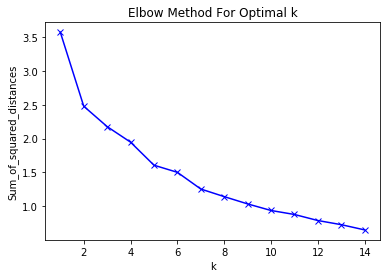

In [70]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [84]:

# set number of clusters
kclusters = 7

#toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [85]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() 

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Pub,Bakery,Park,Breakfast Spot,Café,Theater,Yoga Studio,Event Space,Restaurant
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Diner,Sushi Restaurant,Yoga Studio,Park,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Clothing Store,Coffee Shop,Café,Japanese Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Cosmetics Shop,Diner,Tea Room,Electronics Store
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,Gastropub,Restaurant,American Restaurant,Cocktail Bar,Gym,Hotel,Italian Restaurant,Japanese Restaurant
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Trail,Asian Restaurant,Health Food Store,Pub,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Yoga Studio


In [46]:
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

In [47]:
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [75]:
address = 'Toronto'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [86]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

ANALYSE CLUSTERS

In [99]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].shape

(5, 12)

In [100]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,East Toronto,0,Trail,Asian Restaurant,Health Food Store,Pub,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Yoga Studio
9,West Toronto,0,Bakery,Pharmacy,Grocery Store,Supermarket,Bar,Brazilian Restaurant,Middle Eastern Restaurant,Café,Bank,Music Venue
15,East Toronto,0,Park,Sandwich Place,Fast Food Restaurant,Pizza Place,Pub,Liquor Store,Burrito Place,Italian Restaurant,Restaurant,Intersection
22,West Toronto,0,Grocery Store,Café,Mexican Restaurant,Thai Restaurant,Furniture / Home Store,Fast Food Restaurant,Bookstore,Flea Market,Cajun / Creole Restaurant,Speakeasy
38,East Toronto,0,Light Rail Station,Gym / Fitness Center,Auto Workshop,Skate Park,Smoke Shop,Spa,Farmers Market,Fast Food Restaurant,Burrito Place,Butcher


In [101]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].shape

(29, 12)

In [102]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,1,Coffee Shop,Pub,Bakery,Park,Breakfast Spot,Café,Theater,Yoga Studio,Event Space,Restaurant
1,Downtown Toronto,1,Coffee Shop,Diner,Sushi Restaurant,Yoga Studio,Park,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place
2,Downtown Toronto,1,Clothing Store,Coffee Shop,Café,Japanese Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Cosmetics Shop,Diner,Tea Room,Electronics Store
3,Downtown Toronto,1,Coffee Shop,Café,Gastropub,Restaurant,American Restaurant,Cocktail Bar,Gym,Hotel,Italian Restaurant,Japanese Restaurant
5,Downtown Toronto,1,Coffee Shop,Cocktail Bar,Seafood Restaurant,Bakery,Restaurant,Café,Cheese Shop,Beer Bar,Department Store,Nightclub


In [103]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].shape

(1, 12)

In [106]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,Downtown Toronto,2,Park,Playground,Trail,Deli / Bodega,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant


In [107]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].shape

(1, 12)

In [108]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,3,Park,Yoga Studio,Department Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant


In [109]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].shape

(1, 12)

In [110]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,4,Park,Swim School,Bus Line,Fast Food Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop


In [92]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].shape

(1, 12)

In [111]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,5,Pool,Home Service,Garden,Yoga Studio,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop


In [93]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]].shape

(1, 12)

In [112]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Central Toronto,6,Jewelry Store,Trail,Mexican Restaurant,Sushi Restaurant,Yoga Studio,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant
